In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/test.csv
/kaggle/input/nlp-getting-started/train.csv


In [63]:
import matplotlib.pyplot as plt
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import spacy
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import numpy as np 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.optimizers import SGD
import seaborn as sns

# Intro and Objective


Twitter has become an important communication channel in times of emergency.
The ubiquitousness of smartphones enables people to announce an emergency they’re observing in real-time. Because of this, more agencies are interested in programatically monitoring Twitter (i.e. disaster relief organizations and news agencies).

But, it’s not always clear whether a person’s words are actually announcing a disaster
<img height ="500" width="250" src =  "https://st.depositphotos.com/1032753/4674/v/950/depositphotos_46741417-stock-illustration-twitter-and-social-media-concept.jpg">
<img height ="500" width="250" src =  "https://miro.medium.com/max/1400/0*z9jqZsQ7JSTZGSZz.jpg">

# I - Reading Data

In [3]:
data_train = pd.read_csv("/kaggle/input/nlp-getting-started/train.csv")
data_test = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [4]:
y_train_data = data_train["target"]

In [119]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,deeds reason earthquake may allah forgive us,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,residents asked shelter place notified office...,1
3,6,NaN,NaN,people receive wildfires evacuation orders ca...,1
4,7,NaN,NaN,got sent photo ruby alaska smoke wildfires po...,1


In [6]:
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


# II - Data Understanding

In [7]:
data_train.shape

(7613, 5)

In [8]:
data_train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

# III - Data Cleaning

In [9]:
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [10]:
def eliminate_symbols(text):
    """
    this function allows to keep only letters in the text
    """
    text =re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub("[^a-zA-^Z]", " ", text)
    
    return text

data_train["text"] = data_train["text"].apply(lambda x : eliminate_symbols(x))

In [11]:
#Text to lowercase
data_train["text"] = data_train["text"].apply(lambda x : x.lower())

In [12]:
# Tokenize text
data_train["text"]=data_train["text"].apply(lambda x : word_tokenize(x))

In [13]:
#Eliminate stopwords
def eliminate_stop_words(token):
    new=[]
    for word in token:
        if word not in stopwords.words('english'):
            new.append(word)
    return new

data_train["text"]=data_train["text"].apply(lambda x : eliminate_stop_words(x))


In [14]:
def token_toString(token):
    """
    After transforming sentenses to token we need to return them as sentences
    """
    text=""
    for j in token:
        text+=" "+j
    return text
data_train["text"]=data_train["text"].apply(lambda x : token_toString(x))


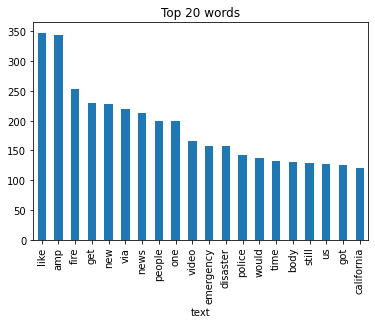

In [15]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_n_words(data_train['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 words')


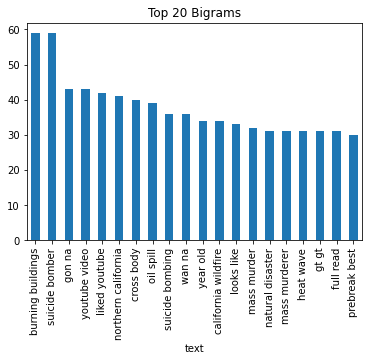

In [16]:
def get_top_bi_words(corpus, n=None):
    vec = CountVectorizer(ngram_range=(2, 2)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

common_words = get_top_bi_words(data_train['text'], 20)
df2 = pd.DataFrame(common_words, columns = ['text' , 'count'])
df2.groupby('text').sum()['count'].sort_values(ascending=False).plot(
    kind='bar', title='Top 20 Bigrams')

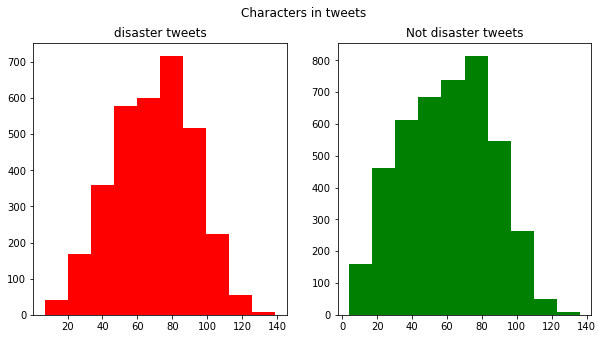

In [17]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
tweet_len=data_train[data_train['target']==1]['text'].str.len()
ax1.hist(tweet_len,color='red')
ax1.set_title('disaster tweets')
tweet_len=data_train[data_train['target']==0]['text'].str.len()
ax2.hist(tweet_len,color='green')
ax2.set_title('Not disaster tweets')
fig.suptitle('Characters in tweets')
plt.show()

# III - Data Preparaton

### 1 - Spacy Vectorizer

In [18]:
nlp = spacy.load('en_core_web_lg')
train_vectors = np.array([nlp(text).vector for text in data_train['text']])
test_vectors = np.array([nlp(text).vector for text in data_test['text']])

### 2 - Extracting features from text with CountVectorizer

In [19]:
# Here is a little example to see how CountVectorizer works
# it takes all the vocabulary in the dataset and make each word as feature the it puts zeros and ones the feature for each sentence
# in the dataset
count_vect = CountVectorizer()
X_data_count = count_vect.fit_transform(["when i saw your shadow","I am swimming am and the waves kicked me out"])
print(pd.DataFrame(X_data_count.A, columns=count_vect.get_feature_names()).to_string())

   am  and  kicked  me  out  saw  shadow  swimming  the  waves  when  your
0   0    0       0   0    0    1       1         0    0      0     1     1
1   2    1       1   1    1    0       0         1    1      1     0     0


In [20]:
count_vect = CountVectorizer()
count_vect.fit(data_train['text'])

train_vectors1 = count_vect.transform(data_train['text'])
test_vectors1 = count_vect.transform(data_test['text'])

The problem here is that the Machine Learning algorithm will give more weightage to longer documents (sentenses) beacause 
they will have more ones as values in features. To avoid this issue we will use TF-IDF.
<br>
<br>

TF-IDF : Term frequency inverse document frequence <br>
Let's take an exemple : "We are Hexagon, we are DataScientists"<br>
TFIDF("We") = 2/6 <br>
TFIDF("DataScientits") = 1/6 <br>

In [21]:
tfidf_transformer = TfidfTransformer()
X_data_train_tfidf = tfidf_transformer.fit_transform(train_vectors1)
X_data_test_tfidf = tfidf_transformer.transform(test_vectors1)

# VI - Modeling and prediction

### 1 - Splitting train_data to train and test sets

In [22]:
X_train_spacy_vectorizer, X_test_spacy_vectorizer, y_train_spacy_vectorizer, y_test_spacy_vectorizer = train_test_split(train_vectors, y_train_data, test_size= 0.2, shuffle= True, random_state= 42)

In [23]:
X_train_count_vectorizer, X_test_count_vectorizer, y_train_count_vectorizer, y_test_count_vectorizer = train_test_split(train_vectors1, y_train_data, test_size= 0.2, shuffle= True, random_state= 42)

### 2- Applying machine learning algorithms

##### a - SVM classifier Spacy vectorizer data

In [24]:
svc = LinearSVC(dual= False, max_iter= 10000, random_state= 1)
svc.fit(X_train_spacy_vectorizer, y_train_spacy_vectorizer)

print(f'Accuracy Score : {svc.score(X_train_spacy_vectorizer, y_train_spacy_vectorizer):.3f}')


Accuracy Score : 0.821


In [25]:
y_pred =svc.predict(X_test_spacy_vectorizer)


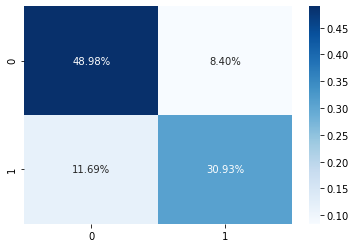

In [34]:
cm =confusion_matrix(y_test_spacy_vectorizer, y_pred)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

In [26]:
print(classification_report(y_test_spacy_vectorizer, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       874
           1       0.79      0.73      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



##### b - SVM classifier count vectorizer data

In [106]:

svc = LinearSVC(dual= False, max_iter= 10000, random_state= 1)
svc.fit(X_train_count_vectorizer, y_train_count_vectorizer)

print(f'Accuracy Score : {svc.score(X_train_count_vectorizer, y_train_count_vectorizer):.3f}')


Accuracy Score : 0.988


In [107]:
y_pred_count =svc.predict(X_test_count_vectorizer)
print(classification_report(y_test_count_vectorizer, y_pred_count))

              precision    recall  f1-score   support

           0       0.78      0.82      0.80       874
           1       0.74      0.70      0.72       649

    accuracy                           0.77      1523
   macro avg       0.76      0.76      0.76      1523
weighted avg       0.77      0.77      0.77      1523



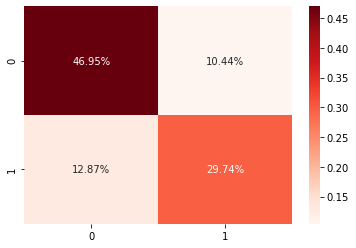

In [37]:
cm =confusion_matrix(y_test_count_vectorizer, y_pred_count)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Reds')

##### c - Logisitic Regression with Spacy Vectorizer

In [94]:
logreg_basic = LogisticRegression()
logreg_basic.fit(X_train_spacy_vectorizer, y_train_spacy_vectorizer)
y_pred_logistic_spacy = logreg_basic.predict(X_test_spacy_vectorizer)

In [95]:
print(classification_report(y_test_spacy_vectorizer, y_pred_logistic_spacy))

              precision    recall  f1-score   support

           0       0.81      0.85      0.83       874
           1       0.78      0.74      0.76       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.80      1523
weighted avg       0.80      0.80      0.80      1523



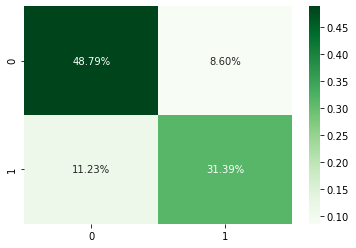

In [96]:
cm =confusion_matrix(y_test_spacy_vectorizer, y_pred_logistic_spacy)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Greens')

##### d - Logisitic Regression with Count Vectorizer

In [42]:
logreg_basic = LogisticRegression(C=1.0)
logreg_basic.fit(X_train_count_vectorizer, y_train_count_vectorizer)
y_pred_logistic_count = logreg_basic.predict(X_test_count_vectorizer)

In [43]:
print(classification_report(y_test_count_vectorizer, y_pred_logistic_count))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83       874
           1       0.79      0.71      0.75       649

    accuracy                           0.80      1523
   macro avg       0.80      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523



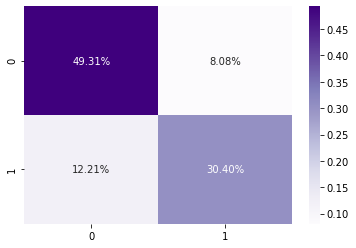

In [45]:
cm =confusion_matrix(y_test_count_vectorizer, y_pred_logistic_count)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Purples')

##### e - AdaBoost with Spacy Vectorizer data

In [46]:
classifier_spacy = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1),
                                 n_estimators=200,
                                learning_rate=1
                               )
classifier_spacy.fit(X_train_spacy_vectorizer,y_train_spacy_vectorizer)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [47]:
y_pred_adaboost_spacy = classifier_spacy.predict(X_test_spacy_vectorizer)

In [48]:
print(classification_report(y_test_spacy_vectorizer, y_pred_adaboost_spacy))

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       874
           1       0.74      0.73      0.73       649

    accuracy                           0.77      1523
   macro avg       0.77      0.77      0.77      1523
weighted avg       0.77      0.77      0.77      1523



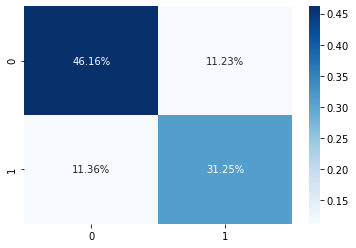

In [53]:
cm =confusion_matrix(y_test_spacy_vectorizer, y_pred_adaboost_spacy)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

##### f - AdaBoost with Count vectorizer data

In [54]:
classifier = AdaBoostClassifier( DecisionTreeClassifier(max_depth=1),
                                 n_estimators=200,
                                learning_rate=1.0
                               )
classifier.fit(X_train_count_vectorizer,y_train_count_vectorizer)

AdaBoostClassifier(algorithm='SAMME.R',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='gini',
                                                         max_depth=1,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=1,
                                                         min_samples_split=2,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                          

In [82]:
y_pred_adaboost_count = classifier.predict(X_test_count_vectorizer)


In [56]:
print(classification_report(y_test_count_vectorizer, y_pred_adaboost_count))

              precision    recall  f1-score   support

           0       0.76      0.84      0.80       874
           1       0.75      0.65      0.70       649

    accuracy                           0.76      1523
   macro avg       0.76      0.74      0.75      1523
weighted avg       0.76      0.76      0.76      1523



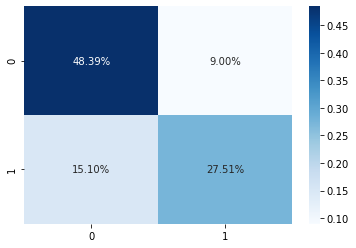

In [57]:
cm =confusion_matrix(y_test_count_vectorizer, y_pred_adaboost_count)
sns.heatmap(cm/np.sum(cm), annot=True, 
            fmt='.2%', cmap='Blues')

##### g - Logistic Regression with cross validation

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_predict
from sklearn import metrics

predicted = cross_val_predict(LogisticRegression(), train_vectors, y_train_data, cv=9)
print( metrics.accuracy_score(y_train_data, predicted))





/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


0.7614606593983975


In [60]:
print (classification_report(y_train_data, predicted))

              precision    recall  f1-score   support

           0       0.77      0.82      0.80      4342
           1       0.74      0.68      0.71      3271

    accuracy                           0.76      7613
   macro avg       0.76      0.75      0.75      7613
weighted avg       0.76      0.76      0.76      7613



##### h - Neural Network

In [64]:
train_vectors1[0].T.shape

(16047, 1)

In [65]:
model = Sequential()

model.add(Dense(512, input_dim=16047, activation='relu', name='fc1'))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu', name='fc2'))
model.add(Dropout(0.2))
model.add(Dense(128, activation='relu', name='fc3'))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid', name='output'))

sgd = SGD(lr=0.1)
model.compile(loss='mean_squared_error', optimizer=sgd)
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
fc1 (Dense)                  (None, 512)               8216576   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
fc2 (Dense)                  (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
fc3 (Dense)                  (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
output (Dense)               (None, 1)                

In [67]:
history=model.fit(train_vectors1.toarray(), y_train_data, batch_size=4, nb_epoch=20, verbose=1)
print(np.around(model.predict_proba(train_vectors1.toarray())))

Train on 7613 samples
Epoch 1/20
7613/7613 [==============================] - 24s 3ms/sample - loss: 0.0226
Epoch 2/20
7613/7613 [==============================] - 25s 3ms/sample - loss: 0.0211
Epoch 3/20
7613/7613 [==============================] - 25s 3ms/sample - loss: 0.0220
Epoch 4/20
7613/7613 [==============================] - 24s 3ms/sample - loss: 0.0216
Epoch 5/20
7613/7613 [==============================] - 25s 3ms/sample - loss: 0.0206
Epoch 6/20
7613/7613 [==============================] - 34s 4ms/sample - loss: 0.0204
Epoch 7/20
7613/7613 [==============================] - 26s 3ms/sample - loss: 0.0201
Epoch 8/20
7613/7613 [==============================] - 26s 3ms/sample - loss: 0.0195
Epoch 9/20
7613/7613 [==============================] - 25s 3ms/sample - loss: 0.0188
Epoch 10/20
7613/7613 [==============================] - 26s 3ms/sample - loss: 0.0182
Epoch 11/20
7613/7613 [==============================] - 25s 3ms/sample - loss: 0.0186
Epoch 12/20
7613/7613 [=======

In [68]:
from sklearn.metrics import roc_curve, auc

fpr1, tpr1, threshold1 = roc_curve(y_test_spacy_vectorizer, y_pred)
roc_auc1 = auc(fpr1, tpr1)


fpr2, tpr2, threshold2 = roc_curve(y_test_count_vectorizer, y_pred_count)
roc_auc2 = auc(fpr2, tpr2)


fpr3, tpr3, threshold3 = roc_curve(y_test_count_vectorizer, y_pred_logistic_count)
roc_auc3 = auc(fpr3, tpr3)


fpr4, tpr4, threshold4 = roc_curve(y_test_spacy_vectorizer, y_pred_logistic_spacy)
roc_auc4 = auc(fpr4, tpr4)


fpr5, tpr5, threshold5 = roc_curve(y_pred_adaboost_spacy, y_test_spacy_vectorizer)
roc_auc5 = auc(fpr5, tpr5)



fpr6, tpr6, threshold6 = roc_curve(y_pred_adaboost_count, y_test_count_vectorizer)
roc_auc6 = auc(fpr6, tpr6)

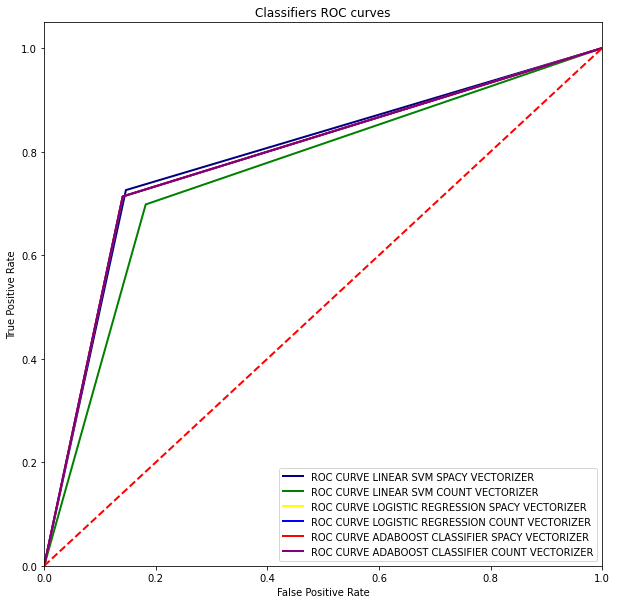

In [71]:
plt.figure(figsize=(10,10)) 
plt.plot(fpr1, tpr1, color='navy', lw=2, label='ROC CURVE LINEAR SVM SPACY VECTORIZER'% roc_auc1)
plt.plot(fpr2, tpr2, color='green', lw=2, label='ROC CURVE LINEAR SVM COUNT VECTORIZER'% roc_auc2)
plt.plot(fpr3, tpr3, color='yellow', lw=2, label='ROC CURVE LOGISTIC REGRESSION SPACY VECTORIZER'% roc_auc4)

plt.plot(fpr3, tpr3, color='blue', lw=2, label='ROC CURVE LOGISTIC REGRESSION COUNT VECTORIZER'% roc_auc3)
plt.plot(fpr3, tpr3, color='red', lw=2, label='ROC CURVE ADABOOST CLASSIFIER SPACY VECTORIZER'% roc_auc5)
plt.plot(fpr3, tpr3, color='purple', lw=2, label='ROC CURVE ADABOOST CLASSIFIER COUNT VECTORIZER'% roc_auc6)

plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') 
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.05]) 
plt.xlabel('False Positive Rate') 
plt.ylabel('True Positive Rate') 
plt.title('Classifiers ROC curves') 
plt.legend(loc = "lower right")
plt.show()

# V - Submission

In [108]:
y_pred_count =svc.predict(test_vectors1)

In [109]:
data_submission = pd.read_csv("/kaggle/input/nlp-getting-started/test.csv")

In [110]:
data_submission

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [111]:

data_submission["target"] = y_pred_adaboost_count

In [112]:
data_submission = data_submission.loc[:,["id",'target']]

In [113]:
data_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [114]:
def classify(output):
    if output > 0.5:
        return 1
    else:
        return 0
    

In [115]:
data_submission["target"] = data_submission["target"].apply(lambda x : classify(x))
data_submission

,id,target
0,0,1
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [116]:
data_submission.to_csv('submission.csv', index=False)